In [1]:
import haiku as hk
import h5py
import os
import sys
sys.path.append(os.path.abspath("birdflow/birdflow-bilevel/src/"))
from flow_model_training import loss_fn, mask_input, Datatuple, train_model, w2_loss_fn
from flow_model import model_forward
from hdfs import get_plot_parameters
import numpy as np
import optax
from functools import partial
from jax import jit
import jax.numpy as jnp
from ott.geometry.pointcloud import PointCloud
from ott.geometry.geometry import Geometry
from ott.geometry.costs import CostFn
from ott.solvers import linear
from ott.solvers.linear.implicit_differentiation import ImplicitDiff
import jax
from jaxtyping import Float, Array, Int
from typing import Any, Union
import functools
from tqdm import tqdm
import matplotlib.pyplot as plt
from beartype import (
    beartype,
    BeartypeConf,
    BeartypeStrategy,
)
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype

## Learning an S&T distribution with W2 distance

In [8]:
hdf_src = 'birdflow/birdflow-bilevel/ebird-data-loading/amewoo_2021_39km.hdf5'

with h5py.File(hdf_src, 'r') as file:
    true_densities = np.asarray(file['distr']).T

    weeks = true_densities.shape[0]
    total_cells = true_densities.shape[1]

    dist_pow = 0.1
    distance_vector = np.asarray(file['distances'])**dist_pow
    distance_vector *= 1 / (100**dist_pow) # normalize the distance vector
    ncol, nrow, dynamic_masks, big_mask = get_plot_parameters(hdf_src)

    dtuple = Datatuple(weeks, ncol, nrow, total_cells, distance_vector, dynamic_masks, big_mask)
    distance_matrices, distance_matrices_for_week, masked_densities = mask_input(true_densities, dtuple)

In [9]:
eps_defaults = []
for i, distance_matrix in enumerate(distance_matrices_for_week):
    geom = Geometry(cost_matrix=distance_matrix, epsilon=None)
    eps_defaults.append(geom.epsilon)

In [10]:
print(masked_densities[0])
print(jnp.sum(masked_densities[0]))
print(jnp.mean(distance_matrices_for_week[0]))
print(jnp.max(distance_matrices_for_week[0]))
print(jnp.min(distance_matrices_for_week[0]))
print(jnp.std(distance_matrices_for_week[0]))

[2.75533562e-06 1.19970601e-05 2.14966816e-05 ... 1.55415614e-07
 2.91564749e-07 4.37049889e-08]
1.0
1.2297753
1.4226154
0.0
0.09399295


In [11]:
sinkhorn_solver = jit(linear.solve, static_argnames=['max_iterations', 'progress_fn'])

class Scheduler:
    @beartype(conf=BeartypeConf(strategy=(BeartypeStrategy.O0)))
    def __init__(self, target, init, decay, decay_after):
        self.target = target
        self.init = init
        self.decay = decay
        self.decay_after = decay_after
    
    def get_epsilon(self, it: Int[Array, ""]):
        """
        At training step it, get a value of epsilon
        """
        epsilon = self.init * self.target
        epsilon = jax.lax.cond(it > self.decay_after,
                     lambda t : jax.lax.cond(t - self.decay * (it - self.decay_after) > self.target, lambda s : t - self.decay * (it - self.decay_after), lambda s: self.target, None),
                     lambda t: t,
                     epsilon)  # linear decay   
        return epsilon

def w2_distance(mu: Float[Array, "n "], mu_true: Float[Array, "n "], distance_matrix: Float[Array, "n n"], epsilon: Union[Float[Array, ""], Any]):
    geom = Geometry(cost_matrix=distance_matrix, epsilon=epsilon)
    ot = sinkhorn_solver(geom, implicit_diff=ImplicitDiff(), a=mu, b=mu_true, max_iterations=5000)
    return ot.reg_ot_cost

def loss_fn(theta: Float[Array, "n "], st_marginal: Float[Array, "n "], distance_matrix: Float[Array, "n n"], epsilon: Union[Float[Array, ""], Any]):
    mu = jax.nn.softmax(theta)
    return w2_distance(mu, st_marginal, distance_matrix, epsilon)

def logit_l2_loss(theta: Float[Array, "n "], marginal: Float[Array, "n "]):
    """
    l2 distance between logits and probability distribution
    """
    mu = jax.nn.softmax(theta)
    return jnp.sqrt(jnp.sum((mu - marginal)**2))

def learn_st_marginal(st_marginal: Float[Array, "n"], 
                      distance_matrix: Float[Array, "n n"], 
                      seed=42,
                      training_steps=500, 
                      epsilon: Union[float, Any]=None, 
                      tau: float=1.0, 
                      lr: float=1e-3, 
                      init_from_mu_true: bool=False, 
                      use_adam: bool=True, 
                      use_stabilization: bool=False, 
                      scheduler: Union[Scheduler, Any]=None,
                      loss_fn=loss_fn):
    
    solver = optax.adam(learning_rate=lr)
    key = jax.random.PRNGKey(seed)
    key, subkey = jax.random.split(key)
    
    # if init_from_mu_true:  # initialize at the true marginal
    #     mu_true_logits = jnp.log(mu_true)
    #     theta_init = mu_true_logits
    # else:
    #     theta_init = jnp.zeros(shape=X.shape[0]) # uniform initialization

    # initialize parameter values
    theta_init = jnp.zeros(shape=st_marginal.shape[0]) # uniform initialization    
    
    # initialize solver
    theta = theta_init
    opt_state = solver.init(theta)
    
    # create loss function
    loss_fn = functools.partial(loss_fn, st_marginal=st_marginal, distance_matrix=distance_matrix)
    grad_loss_fn = jax.value_and_grad(loss_fn)
    
    @jax.jit
    def make_step_adam(theta, epsilon, opt_state):
        loss_val, grads = grad_loss_fn(theta, epsilon=epsilon)
        updates, opt_state = solver.update(grads, opt_state)
        theta = optax.apply_updates(theta, updates)
        return loss_val, theta, opt_state
    
    @jax.jit
    def make_step(theta, epsilon, opt_state):
        loss_val, grads = grad_loss_fn(theta, epsilon)
        theta = theta - lr * grads
        return loss_val, theta, None
    
    @jax.jit
    def make_step_stabilized(theta, epsilon, opt_state):
        loss_val, grads = grad_loss_fn(theta, epsilon)
        theta = theta - lr * grads
        
        # stabilize by subtracting max from theta
        theta = theta - jnp.max(theta) # softmax(X - c) = softmax(X) 
        
        return loss_val, theta, None
    
    if use_adam:
        make_step = make_step_adam
    if use_stabilization:
        make_step = make_step_stabilized
    
    w2_loss_vals = []
    l2_loss_vals = []
    thetas = {}
    if scheduler != None:
        get_epsilon = jax.jit(scheduler.get_epsilon)
    for step in tqdm(range(1, training_steps + 1), desc="Training Steps", unit="step"):
        if scheduler != None:
            epsilon = float(get_epsilon(step))
        loss_val, theta, opt_state = make_step(theta, epsilon, opt_state)
        if step % int(training_steps / 40) == 0:
            thetas[step] = theta
        w2_loss_vals.append(loss_val)
        l2_loss_val = logit_l2_loss(theta, st_marginal)
        l2_loss_vals.append(l2_loss_val)
        #print(f"iteration {step}, loss value {loss_val}, l2 loss: {l2_loss_val}")
    
    return theta, thetas, (w2_loss_vals, l2_loss_vals)

In [12]:
def make_grid(marginal, mask, big_mask, x_dim, y_dim):
    """
    Arguments
    week: the week whose marginal we wish to fill into the grid to be plotted
    marginal: the marginal from week "week"
    mask: the dynamic mask.
    big_mask: the mask used to eliminate oceans
    x_dim: number of columns of final grid
    y_dim: number of rows of the final grid

    Returns:
    A grid with all the densities of the weekly marginals filled in
    """
    medium_grid = np.zeros(mask.shape[0])
    medium_grid[mask] = marginal
    big_grid = np.empty(big_mask.shape[0])
    big_grid.fill(np.nan)
    big_grid[big_mask] = medium_grid
    return big_grid.reshape(y_dim, x_dim)

Training Steps: 100%|██████████| 1750/1750 [01:38<00:00, 17.83step/s]


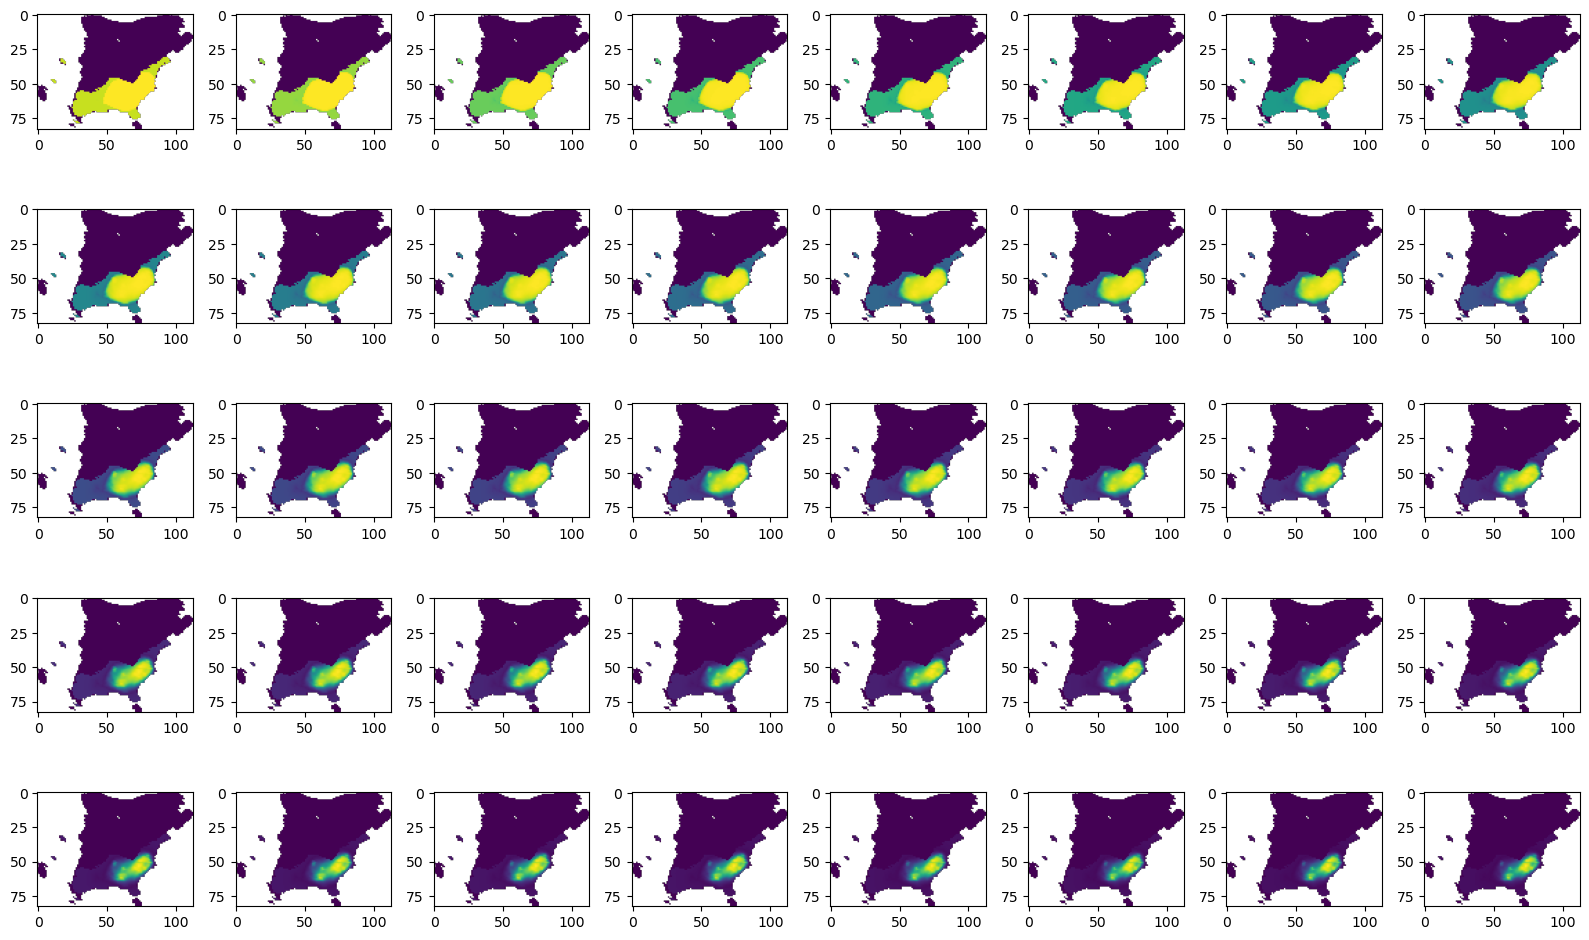

In [15]:
week = 0
st_marginal = jnp.array(masked_densities[week])
distance_matrix = distance_matrices_for_week[week]
eps_default = eps_defaults[week]
n_steps = 1750
scheduler = Scheduler(eps_default * 0.01, 10000, 8.006883e-05, 1500)
lr = 1e-3
learned, thetas, (w2_loss_vals, l2_loss_vals) = learn_st_marginal(st_marginal, distance_matrix, training_steps=n_steps, scheduler=scheduler, lr=lr)

# plot difference between learned / ground truth st at each step
fig, axes = plt.subplots(5, 8, figsize=(16, 10))
ax_list = axes.flat
for i, (step, theta) in enumerate(thetas.items()):
    learned_st = jax.nn.softmax(theta)
    grid_learned = make_grid(learned_st, dynamic_masks[week], big_mask, ncol, nrow)
    # grid_true = make_grid(st_marginal, dynamic_masks[week], big_mask, ncol, nrow)
    # diff_grid = jnp.abs(grid_learned - grid_true)
    pos = ax_list[i].imshow(grid_learned)
    # ax_list[i].colorbar(pos)
    
plt.tight_layout()
plt.show()

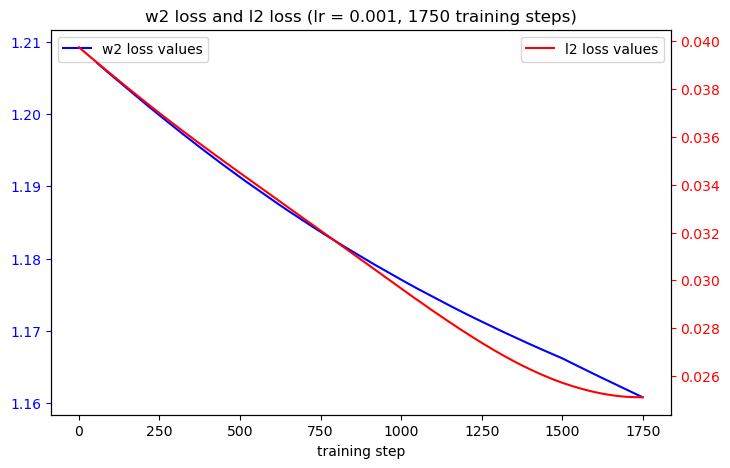

In [97]:
# Create figure and first y-axis (left)
fig, ax_left = plt.subplots(figsize=(8, 5))
ax_left.plot(list(range(n_steps)), w2_loss_vals, 'b', label='w2 loss values')
#ax_left.set_ylabel("w2 loss value", color='b')
ax_left.tick_params(axis='y', colors='b')

# Create second y-axis (right)
ax_right = ax_left.twinx()  # Mirror y-axis on the right
ax_right.plot(list(range(n_steps)), l2_loss_vals, 'r', label='l2 loss values')  # Red dashed line for cos(x)
#ax_right.set_ylabel("l2 loss value", color='r')
ax_right.tick_params(axis='y', colors='r')

# Set labels and title
ax_left.set_xlabel(f"training step")
plt.title(f"w2 loss and l2 loss (lr = {lr}, {n_steps} training steps)")

# Add legends
ax_left.legend(loc="upper left")
ax_right.legend(loc="upper right")

# Show plot
plt.show()

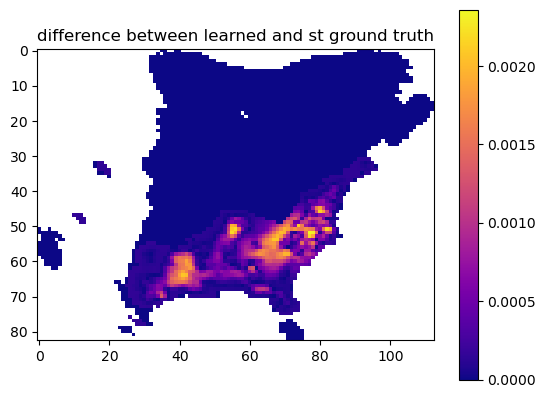

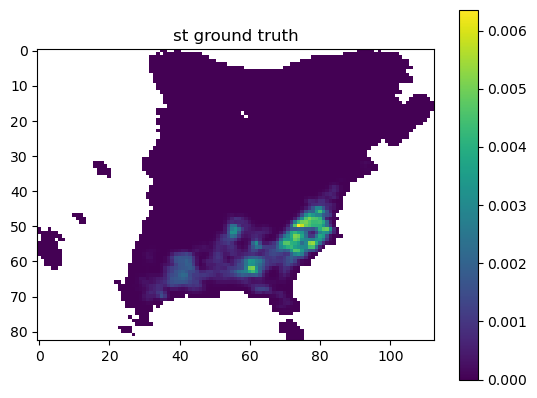

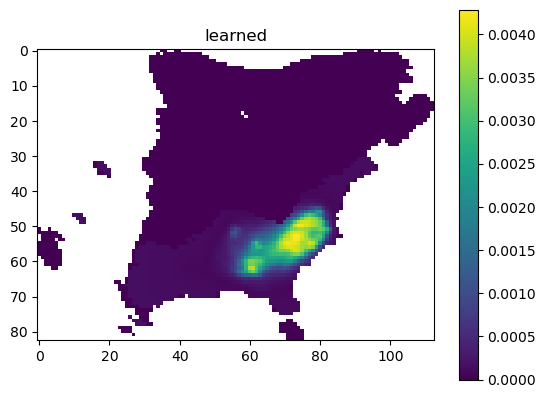

In [109]:
def make_grid(marginal, mask, big_mask, x_dim, y_dim):
    """
    Arguments
    week: the week whose marginal we wish to fill into the grid to be plotted
    marginal: the marginal from week "week"
    mask: the dynamic mask.
    big_mask: the mask used to eliminate oceans
    x_dim: number of columns of final grid
    y_dim: number of rows of the final grid

    Returns:
    A grid with all the densities of the weekly marginals filled in
    """
    medium_grid = np.zeros(mask.shape[0])
    medium_grid[mask] = marginal
    big_grid = np.empty(big_mask.shape[0])
    big_grid.fill(np.nan)
    big_grid[big_mask] = medium_grid
    return big_grid.reshape(y_dim, x_dim)

plt.figure(1)
learned_st = jax.nn.softmax(learned)
grid_learned = make_grid(learned_st, dynamic_masks[0], big_mask, ncol, nrow)
grid_true = make_grid(st_marginal, dynamic_masks[0], big_mask, ncol, nrow)
diff_grid = jnp.abs(grid_learned - grid_true)
pos = plt.imshow(diff_grid, cmap="plasma")
plt.colorbar(pos)
plt.title("difference between learned and st ground truth")

plt.figure(2)
plt.title("st ground truth")
pos = plt.imshow(grid_true, cmap="viridis")
plt.colorbar(pos)
plt.show()

plt.figure(3)
plt.title("learned")
pos = plt.imshow(grid_learned, cmap="viridis")
plt.colorbar(pos)
plt.show()

## Training with the full model

In [4]:
hdf_src = '/work/pi_drsheldon_umass_edu/birdflow_modeling/jacob_independent_study/birdflow-bilevel/ebird-data-loading/amewoo_2021_39km.hdf5'
file = h5py.File(hdf_src, 'r+')

true_densities = np.asarray(file['distr']).T

weeks = true_densities.shape[0]
total_cells = true_densities.shape[1]

dist_pow = 0.1
distance_vector = np.asarray(file['distances'])**dist_pow
distance_vector *= 1 / (100**dist_pow) # normalize the distance vector
ncol, nrow, dynamic_masks, big_mask = get_plot_parameters(hdf_src)

dtuple = Datatuple(weeks, ncol, nrow, total_cells, distance_vector, dynamic_masks, big_mask)
print(jnp.sum(jnp.asarray(true_densities[5, :])))
distance_matrices, distance_matrices_for_week, masked_densities = mask_input(true_densities, dtuple)
cells = [d.shape[0] for d in masked_densities]
print(cells)
# Get the random seed and optimizer
key = hk.PRNGSequence(42)
optimizer = optax.adam(1e-3)

# Instantiate loss function
obs_weight = 1
dist_weight = 0.5
ent_weight = 0.5
loss_fn = jit(partial(loss_fn,
                      cells=cells,
                      true_densities=masked_densities, 
                      d_matrices=distance_matrices, 
                      obs_weight=obs_weight, 
                      dist_weight=dist_weight,
                      ent_weight=ent_weight))
w2_loss_fn = partial(w2_loss_fn,
                      cells=cells,
                      true_densities=masked_densities,
                      d_matrices=distance_matrices,
                      d_matrices_for_week=distance_matrices_for_week,
                      obs_weight=obs_weight,
                      dist_weight=dist_weight,
                      ent_weight=ent_weight)


# Run Training and get params and losses
# training_steps = 10
# params, loss_dict = train_model(loss_fn,
#                                 optimizer,
#                                 training_steps,
#                                 cells,
#                                 dtuple.weeks,
#                                 key)

1.0
[1287, 1327, 1383, 1472, 1616, 1735, 1921, 2058, 2031, 2112, 2273, 2441, 2675, 2812, 2792, 2788, 2827, 2768, 2750, 2671, 2568, 2402, 2267, 2240, 1969, 2064, 2303, 2282, 2037, 2095, 2015, 2028, 1916, 1887, 1955, 1944, 2163, 2337, 2264, 2410, 2617, 2924, 3128, 2989, 2729, 2105, 1764, 1437, 1401, 1297, 1305, 1306, 1287]


In [5]:
file.close()

In [ ]:
key = hk.PRNGSequence(42)
params = model_forward.init(next(key), cells, weeks)
pred = model_forward.apply(params, None, cells, weeks)
#standard_loss_val = loss_fn(params)
w2_loss_val = w2_loss_fn(params)
#print(standard_loss_val)
print(w2_loss_val)

computed w2 loss for week 1
computed w2 loss for week 2
computed w2 loss for week 3
computed w2 loss for week 4
computed w2 loss for week 5
computed w2 loss for week 6
computed w2 loss for week 7
computed w2 loss for week 8
computed w2 loss for week 9
computed w2 loss for week 10
computed w2 loss for week 11
computed w2 loss for week 12
computed w2 loss for week 13
computed w2 loss for week 14
computed w2 loss for week 15
computed w2 loss for week 16
computed w2 loss for week 17
computed w2 loss for week 18
computed w2 loss for week 19
computed w2 loss for week 20
computed w2 loss for week 21
computed w2 loss for week 22
computed w2 loss for week 23
computed w2 loss for week 24


In [ ]:
a = jnp.linspace(0, 10, 5)
x = a.reshape((a.shape[0], 1)).astype(float)
pc = PointCloud(x, x)

class CustomCostFn(CostFn):
    def __init__(self):
        super().__init__()
        self.cost_matrix = 10 * jnp.ones((10, 10))
    def __call__(self, x, y):
        pass
    def all_pairs(self, x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
        '''
        See https://ott-jax.readthedocs.io/en/latest/_modules/ott/geometry/costs.html#CostFn.all_pairs
        '''
        return self.cost_matrix
custom_cost_mat = 10 * jnp.ones((10, 10))
geom = Geometry(cost_matrix=custom_cost_mat)
print(geom.cost_matrix)

[[10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
 [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
 [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
 [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
 [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
 [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
 [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
 [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
 [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
 [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]]


In [ ]:
arr = jnp.array([[1, 2], [3, 4]])

def fn(x, y):
    print(x.shape)
    print(y.shape)
    return arr[x, y]  # Direct indexing works inside vmap

vmapped_fn = jax.vmap(fn)

# Batch inputs
x_batch = jnp.array([0, 1])  # Row indices
y_batch = jnp.array([1, 0])  # Column indices

result = vmapped_fn(jnp.array([[0]]), jnp.array([[1]]))
print(result)

(1,)
(1,)
[[2]]


In [ ]:
print(os.getcwd())

/Users/jacobepstein/Documents/work
